# Glimpse K12:
## ROI Analysis to help K12 Schools Optimize Mastery

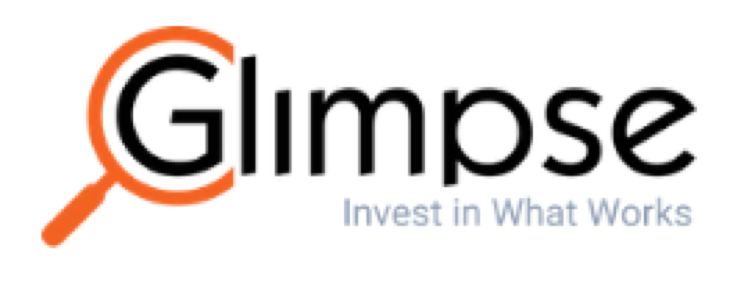

Glimpse K12 is a company that helps school districts understand where they are spending their money and what educational returns they are getting on their investment. As the company has grown in size (and data!), they are increasingly interested in doing more with what they have, and improve educational return on investment even further. 

Enter Insight. This article walks you through how Glimpse went from providing correlational tables and basic statistics, to matching students with the optimal teacher and educational tools to optimize their success machine learning. 

This blog is setup as follows:
- Overview of the data and what we're working with. 
- Baseline models to see whether advanced machine learning is even necessary. 
- Exploration of machine learning techniques to work toward a model with actionable insights. 

## The data

## 1. Importing required libraries

In [2]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns #visualization
import matplotlib.pyplot as plt #visualization
%matplotlib inline
sns.set(color_codes=True)

## 2. Loading the data

A note on the data shown in this notebook. Here we're loading in a redacted and pre=processed version of the data that was provided from the company. The original dataframe provided had student names, student IDs, teacher names, and teacher IDs. These data obviously shouldn't be published. So we'll be showing redacted data and a more limited feature set to protect confidentiality. 

In [29]:
data = pd.read_csv('GlimpseRedacted.csv')

## 3. Initial EDA using profile_report()

In [30]:
data.profile_report(correlations={"cramers": {"calculate": False}})

In [31]:
data = data.replace([np.inf, -np.inf], np.nan)

### Histogram of nan per row (one important plot missing from the profile_report)

Text(0, 0.5, 'Number of Observations Out of 78213')

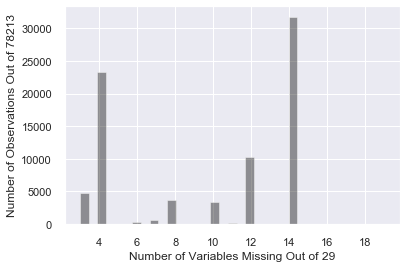

In [32]:
sns.distplot( a=data['numna'], hist=True, kde=False, rug=False, color='black')
plt.xlabel("Number of Variables Missing Out of 29")
plt.ylabel("Number of Observations Out of 78213")

## 4. Split the data into three data frames. 
- most_obs: Keep as many observations as possible and remove features with more than 50% of obs with nan
- most_feats: Keep as many observations as possible and remove observations with a threshold of nan. 
- all_data_recoded: Keep all obs and features and dummy-code nan as missing vals.

### Create most_obs data frame using continuous outcome variables. 

In [79]:
most_obs = data.drop(['ScantronMathPreTest', 'ScantronReadingPreTest', 'ScantronMathMidTest', 'ScantronReadingMidTest', \
                    'IXLMathNonUser', 'IXLMathPartialUser', 'IXLMathUser','IXLReadingNon', 'IXLReadingPartial', \
                    'IXLReadingUser', 'ScantronMathPreTestBenchmarks', 'ScantronReadingPreTestBenchmarks', \
                    'ScantronMathMidTestBenchmarks', 'ScantronReadingMidTestBenchmarks', \
                    'ScantronMathPostTestBenchmarks', 'ScantronReadingPostTestBenchmarks', 'numna'], axis=1)
most_obs = most_obs.dropna()
print("most_obs length:", len(most_obs), "; original length: ", len(data), "difference:", len(data)-len(most_obs))
most_obsCols = list(most_obs)

most_obs length: 77770 ; original length:  78213 difference: 443


#### EDA of most_obs using continuous outcome variables. 

In [81]:
most_obs.profile_report(correlations={"cramers": {"calculate": False}})

### Create most_obs data frame using binary outcome variables. 

In [83]:
most_obs_binary = data.drop(['ScantronMathPreTest', 'ScantronReadingPreTest', 'ScantronMathMidTest', 'ScantronReadingMidTest', \
                    'IXLMathNonUser', 'IXLMathPartialUser', 'IXLMathUser','IXLReadingNon', 'IXLReadingPartial', \
                    'IXLReadingUser', 'ScantronMathPreTestBenchmarks', 'ScantronReadingPreTestBenchmarks', \
                    'ScantronMathMidTestBenchmarks', 'ScantronReadingMidTestBenchmarks', \
                    'ScantronMathPostTest', 'ScantronReadingPostTest', 'numna'], axis=1)
most_obs_binary = most_obs_binary.dropna()
print("most_obs_binary length:", len(most_obs_binary), "; original length: ", len(data), "difference:", len(data)-len(most_obs_binary))
most_obs_binaryCols = list(most_obs_binary)

most_obs_binary length: 77770 ; original length:  78213 difference: 443


In [84]:
most_obs_binary.profile_report(correlations={"cramers": {"calculate": False}})

### Create most_feats data frame using continuous variables

Text(0, 0.5, 'Proportion of \n Participants Available')

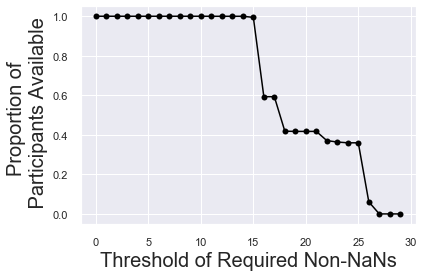

In [46]:
# Determine how many observations we'd lose using different thresholds of nan counts. 
nan_choice = []
for i in range(0, 30):
    most_feat = data.dropna(thresh=i)
    new_len = len(most_feat)
    new_len = new_len/len(data)
    nan_choice.append(new_len)

# Plot it
plt.plot(nan_choice, marker='o', color='black')
plt.xlabel('Threshold of Required Non-NaNs', fontsize='20')
plt.ylabel('Proportion of \n Participants Available', fontsize='20')

#### It looks like a threshold of 3 or fewer nans will still give us approximately 28,132 observations to work with (~ 38% of the original sample). 

In [88]:
most_feats = data.dropna(thresh=25)
print("most_feats length:", len(most_feats), "; original length: ", len(data), "difference:", len(data)-len(most_feats))

most_feats length: 28132 ; original length:  78213 difference: 50081


#### Some of these observations still have a few missing values. So, we'll recode 'nans' as a unique value for each of those variables. NOTE: the only features with nan vals now are categorical columns making this recode straightforward. 

In [75]:
# Show how many nans per variable to prove above Note. 
for i in most_featsCols:
    val = most_feats[i].isna().sum()
    print(i, ":", val)

# Recode nans as missing. 
cols_to_recode = ['IXLMathNonUser', 'IXLMathPartialUser', 'IXLMathUser', 'IXLReadingNon', 'IXLReadingPartial', 'IXLReadingUser']
for i in cols_to_recode:
    most_feats[i] = most_feats[i].fillna('Unknown', inplace=True)

Course : 0
SectionID : 0
Name : 0
TNUM : 0
GR : 0
School : 0
Type : 0
Year : 0
GlimpsestudentId : 0
DistrictID : 0
ScantronMathPreTestBenchmarks : 0
ScantronReadingPreTestBenchmarks : 0
ScantronMathMidTestBenchmarks : 0
ScantronReadingMidTestBenchmarks : 0
ScantronMathPostTestBenchmarks : 0
ScantronReadingPostTestBenchmarks : 0
ScantronMathPreTest : 0
ScantronReadingPreTest : 0
ScantronMathMidTest : 0
ScantronReadingMidTest : 0
ScantronMathPostTest : 0
ScantronReadingPostTest : 0
IXLMathNonUser : 28132
IXLMathPartialUser : 28132
IXLMathUser : 28132
IXLReadingNon : 28132
IXLReadingPartial : 28132
IXLReadingUser : 28132
numna : 0


In [89]:
for i in cols_to_recode:
    print(i, ":", most_feats[i].unique())

IXLMathNonUser : [nan  4.]
IXLMathPartialUser : [ 5. nan]
IXLMathUser : [nan  6.]
IXLReadingNon : [ 1. nan]
IXLReadingPartial : [nan  2.]
IXLReadingUser : [nan  3.]
